### Run only on Colab

In [2]:
! pip install transformers datasets pytorch_metric_learning faiss-gpu umap-learn

  Using cached faiss-gpu-1.7.1.post2.tar.gz (40 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz#sha256=877478752c03678fd9b9553e4ffadca82cd337bba9bb6a939aa1c6ea561a7a58 (from https://pypi.org/simple/faiss-gpu/): Requested faiss-cpu from https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz#sha256=877478752c03678fd9b9553e4ffadca82cd337bba9bb6a939aa1c6ea561a7a58 has inconsistent name: filename has 'faiss-gpu', but metadata has 'faiss-cpu'
  Using cached faiss-gpu-1.7.1.post1.tar.gz (41 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/39/8d/b62bc92c8dd4b2a99d4a06b8804280f6445748b6d698eabb037e111080c7/f

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      running egg_info
      creating C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-mbotmbnx\faiss_cpu.egg-info
      writing C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-mbotmbnx\faiss_cpu.egg-info\PKG-INFO
      writing dependency_links to C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-mbotmbnx\faiss_cpu.egg-info\dependency_links.txt
      writing top-level names to C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-mbotmbnx\faiss_cpu.egg-info\top_level.txt
      writing manifest file 'C:\Users\tomma\AppData\Local\Temp\pip-pip-egg-info-mbotmbnx\faiss_cpu.egg-info\SOURCES.txt'
      error: package directory 'C:\Users\tomma\AppData\Local\Temp\pip-install-oauc6xmi\faiss-gpu_96278aa217794596854f5cb6f9bf9723\faiss\faiss\python' does not exist
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a pr

In [3]:
! wget https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data.json

"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


## Preliminary Steps

In [4]:
from datasets import load_dataset
import numpy as np
import re
from matplotlib import pyplot as plt



dataset = load_dataset('json',data_files='data.json').class_encode_column('artist')
artists_mappings = dataset['train'].features['artist'].names

c:\Users\tomma\Documents\Uni\Magistrale\pyvenvs\ML_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default-1a5eae679f892839
Found cached dataset json (C:/Users/tomma/.cache/huggingface/datasets/json/default-1a5eae679f892839/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
100%|██████████| 1/1 [00:00<00:00, 25.57it/s]
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-425175bc9efee20d.arrow


In [58]:
def clean(example):
    # allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
    allowed_parts = None
    example['lyrics']=example['lyrics'][example['lyrics'].index('Lyrics')+6:] 
    if allowed_parts is not None: 
        for part in allowed_parts:
            example['lyrics']=re.sub("\[.*"+part+".*\]", f"[{part}]", example['lyrics'], flags=re.IGNORECASE)
        example['lyrics']=re.sub("\[(?!"+"|".join(allowed_parts)+").*?\]", "", example['lyrics'], flags=re.DOTALL)
    else: 
        example['lyrics']=re.sub("\[.*\]", "", example['lyrics'], flags=re.IGNORECASE)
    example['lyrics']=re.sub("[0-9]+embed", "", example['lyrics'], flags=re.IGNORECASE)
    return example

mapped_dataset = dataset.map(clean)


100%|██████████| 7185/7185 [00:00<00:00, 8480.13ex/s]


In [59]:
def list_song_parts(example):
    parts = re.findall(r'\[[^\[\]]+\]',example['lyrics']) # Capture everything enclosed in square brackets
    for i,part in enumerate(parts): 
        parts[i] = re.sub(r':.*(?=\])','',part) # Remove everything from : to the closing bracket ] (Most lyrics contain the name of the singer of these parts e.g. [Chorus: 2 Chainz])
    return {'parts': parts}
parts = mapped_dataset['train'].map(list_song_parts,remove_columns=dataset['train'].column_names)

parts:np.ndarray = np.unique([el for l in parts['parts'] for el in l ])

100%|██████████| 7185/7185 [00:00<00:00, 16973.60ex/s]


In [62]:
# print(mapped_dataset)
print(dataset['train'][1000]['lyrics'])
print("----------------")
print(mapped_dataset['train'][1000]['lyrics'])

XO TOUR Llif3 Lyrics[Intro]
Are you alright?
I'm alright, I'm quite alright
And my money's right
8… (Yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(Yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over

[Chorus]
I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said, "Baby, I am not afraid to die"
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge

[Verse 1]
Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, 

In [8]:
allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
def contains_one_of(allowed_parts,part:str):
    for p in allowed_parts:
        if p in part.lower(): return True
    return False
filtered_parts = np.unique([part for part in parts if contains_one_of(allowed_parts,part)])

In [9]:
sorted(filtered_parts)

['[break]',
 '[bridge]',
 '[chorus]',
 '[interlude]',
 '[intro]',
 '[outro]',
 '[verse]']

# Preprocessing

In [10]:
def plot_dist(dataset):
    counts = {}
    for example in dataset:
        if example['artist'] not in counts.keys():
            counts[example['artist']] = 0
        else:
            counts[example['artist']] += 1
    plt.bar(counts.keys(), counts.values())

## Train Test Val Split

In [11]:
from datasets import DatasetDict
tts_mapped_dataset = mapped_dataset['train'].train_test_split(train_size=0.7)
mapped_dataset_valid = tts_mapped_dataset['test'].train_test_split(train_size=0.3)

train_test_val_dataset = DatasetDict({
    'train': tts_mapped_dataset['train'],
    'test':mapped_dataset_valid['test'],
    'val': mapped_dataset_valid['train']
    
})
train_test_val_dataset_filtered = train_test_val_dataset.filter(lambda example: example["artist"]<10)
train_test_val_dataset_filtered

Filter:   0%|          | 0/5029 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1510 [00:00<?, ? examples/s]

Filter:   0%|          | 0/646 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 696
    })
    test: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 210
    })
    val: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 94
    })
})

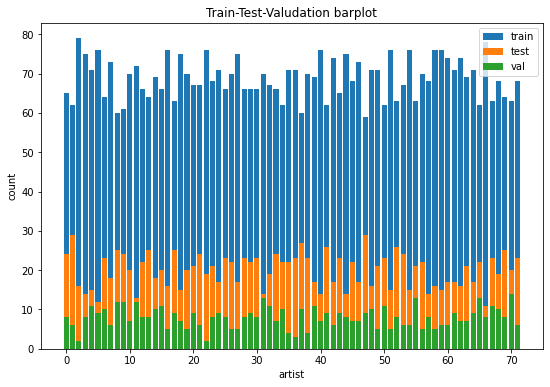

In [12]:
plt.figure(figsize=(9,6))
plt.title("Train-Test-Valudation barplot")
plt.ylabel("count")
plt.xlabel("artist")
plot_dist(train_test_val_dataset['train'])
plot_dist(train_test_val_dataset['test'])
plot_dist(train_test_val_dataset['val'])
plt.legend(['train', 'test', 'val'])
plt.show()

# Machine Learning

In [13]:
from transformers import AutoModel, AutoTokenizer

# Language Model Declaration:

modelckpt="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelckpt)

In [14]:
# Tokenize
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples['lyrics'],
        truncation=True,
        padding=True,
        max_length=512
        )
    tokenized_examples['labels'] = examples['artist']
    return tokenized_examples

# train_features = train_test_val_dataset['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
# test_features = train_test_val_dataset['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
# val_features = train_test_val_dataset['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

train_features = train_test_val_dataset_filtered['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
test_features = train_test_val_dataset_filtered['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
val_features = train_test_val_dataset_filtered['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

Map:   0%|          | 0/696 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

In [36]:
from cycler import cycler

def visualize_embeddings(embeddings, labels,label_mappings):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  plt.figure(figsize=(20,15))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    plt.plot(embeddings[idx,0], embeddings[idx,1], ".", markersize=10, label=label_mappings[label_set[i]])
  plt.legend(loc="best", markerscale=1)
  plt.show()

In [18]:
from prettytable import PrettyTable

def summary(model):
    table = PrettyTable(["Modules", "Parameters","Trainable"])
    table.align["Modules"] = "l"
    total_params = 0
    total_trainable = 0
    for name, parameter in model.named_parameters():
        params = parameter.numel()
        
        if parameter.requires_grad:
          trainable = 'Yes'
          total_trainable += params
        else: 
          trainable = 'No'
        table.add_row([name, params,trainable])
    
        total_params+=params
    print(table)
    print(f"Total Params: {total_params} (Trainable: {total_trainable})")

In [40]:
import torch
import umap
from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from typing import Tuple

device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

class TransformerModel(torch.nn.Module):
    def __init__(self,
                 model_name:str, 
                 hidden_dims:Tuple[int]=(128,)):
        super(TransformerModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dense_layers = torch.nn.ModuleList()
        last_hidden_size = self.transformer.config.hidden_size
        for dim in hidden_dims: 
          self.dense_layers.append(torch.nn.Linear(last_hidden_size, dim))
          last_hidden_size = dim

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids, attention_mask)
        output = outputs["pooler_output"]
        for layer in self.dense_layers: 
          output = torch.nn.functional.relu(layer(output))
        return output

def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    # Train your model
    for batch_idx,batch in enumerate(tqdm(train_loader)):
        # Extract the input ids and attention masks from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Encode the inputs using the pre-trained model
        embeddings = model(input_ids=input_ids, attention_mask=attention_mask)
        # print(embeddings)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "\tEpoch {} Iteration {}:  Number of mined triplets = {}".format(
                    epoch, batch_idx, mining_func.num_triplets
                )
            )

    # Print the loss every epoch
    # print('\tEpoch [{}/{}], Loss: {}'.format(epoch, epochs, loss.item()))

def get_all_embeddings(dataloader, model):
  model.eval()
  embeddings, labels = [], []
  with torch.no_grad():
    for idx, batch in enumerate(tqdm(dataloader)):
      input_ids, attention_mask, label = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
      embeddings.append(model(input_ids=input_ids, attention_mask=attention_mask))
      labels.append(label)

  return torch.vstack(embeddings), torch.cat(labels)

def test(train_loader, test_loader, model, accuracy_calculator):
  train_embeddings, train_labels = get_all_embeddings(train_loader, model)
  test_embeddings, test_labels = get_all_embeddings(test_loader, model)
  accuracies = accuracy_calculator.get_accuracy(test_embeddings, test_labels, train_embeddings, train_labels)

  print(f"Test set accuracy (Precision@1) = {accuracies['precision_at_1']}")

In [41]:
# Load pretrained model
model = TransformerModel(modelckpt,(128,))
model = model.to(device)

summary(model)

# # Freeze all the parameters in the pre-trained model
# for param in model.parameters():
#     param.requires_grad = False

# Define your training data
batch_size = 16
train_loader = DataLoader(train_features,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_features,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_features,batch_size=batch_size, shuffle=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


+----------------------------------------------------------------+------------+-----------+
| Modules                                                        | Parameters | Trainable |
+----------------------------------------------------------------+------------+-----------+
| transformer.embeddings.word_embeddings.weight                  |  23440896  |    Yes    |
| transformer.embeddings.position_embeddings.weight              |   393216   |    Yes    |
| transformer.embeddings.token_type_embeddings.weight            |    1536    |    Yes    |
| transformer.embeddings.LayerNorm.weight                        |    768     |    Yes    |
| transformer.embeddings.LayerNorm.bias                          |    768     |    Yes    |
| transformer.encoder.layer.0.attention.self.query.weight        |   589824   |    Yes    |
| transformer.encoder.layer.0.attention.self.query.bias          |    768     |    Yes    |
| transformer.encoder.layer.0.attention.self.key.weight          |   589824   | 

100%|██████████| 14/14 [00:06<00:00,  2.16it/s]


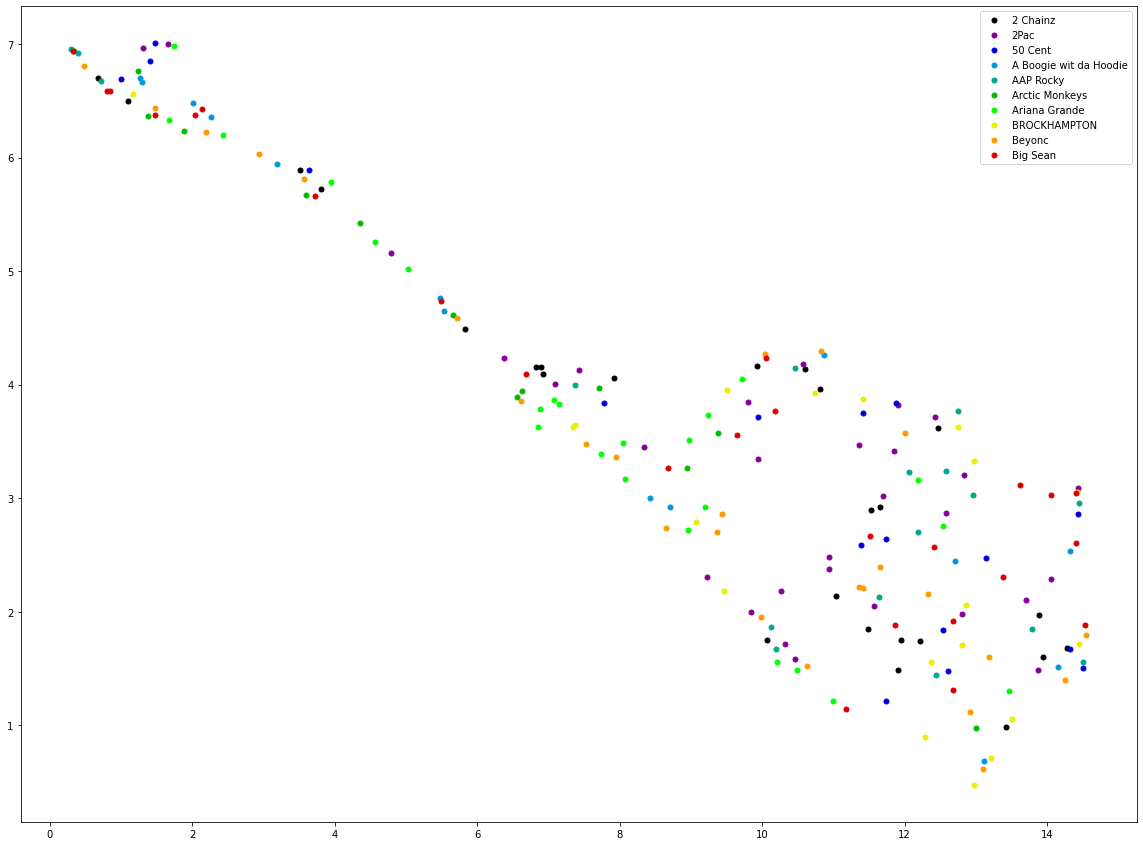

In [42]:
# Visualize the latent space before the training
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(test_loader, model)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings_reduced, labels.cpu().numpy(),artists_mappings)

In [44]:
# Define training hyperparameters
learning_rate = 1e-5
epochs = 10

# Define your optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define the distance and the mining and loss functions
distance = distances.LpDistance(power = 2) # Euclidean distance
margin = 0.1
loss_func = losses.TripletMarginLoss(margin=margin, smooth_loss=True,distance=distance) # triplet loss with margin 0.1
mining_func = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard",distance=distance) # use semihard mining
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1, device=torch.device('cpu'))

for epoch in range(1, epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)


  2%|▏         | 1/44 [00:01<01:02,  1.45s/it]

	Epoch 1 Iteration 0:  Number of mined triplets = 167


 48%|████▊     | 21/44 [00:29<00:32,  1.43s/it]

	Epoch 1 Iteration 20:  Number of mined triplets = 31


 93%|█████████▎| 41/44 [00:59<00:04,  1.44s/it]

	Epoch 1 Iteration 40:  Number of mined triplets = 140


  2%|▏         | 1/44 [00:01<01:01,  1.43s/it]

	Epoch 2 Iteration 0:  Number of mined triplets = 125


 48%|████▊     | 21/44 [00:29<00:32,  1.42s/it]

	Epoch 2 Iteration 20:  Number of mined triplets = 66


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 2 Iteration 40:  Number of mined triplets = 241


  2%|▏         | 1/44 [00:01<01:01,  1.42s/it]

	Epoch 3 Iteration 0:  Number of mined triplets = 159


 48%|████▊     | 21/44 [00:29<00:32,  1.43s/it]

	Epoch 3 Iteration 20:  Number of mined triplets = 128


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 3 Iteration 40:  Number of mined triplets = 151


  2%|▏         | 1/44 [00:01<01:00,  1.40s/it]

	Epoch 4 Iteration 0:  Number of mined triplets = 119


 48%|████▊     | 21/44 [00:29<00:32,  1.42s/it]

	Epoch 4 Iteration 20:  Number of mined triplets = 112


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 4 Iteration 40:  Number of mined triplets = 137


  2%|▏         | 1/44 [00:01<01:00,  1.42s/it]

	Epoch 5 Iteration 0:  Number of mined triplets = 70


 48%|████▊     | 21/44 [00:29<00:32,  1.43s/it]

	Epoch 5 Iteration 20:  Number of mined triplets = 157


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 5 Iteration 40:  Number of mined triplets = 142


  2%|▏         | 1/44 [00:01<01:00,  1.40s/it]

	Epoch 6 Iteration 0:  Number of mined triplets = 143


 48%|████▊     | 21/44 [00:29<00:32,  1.42s/it]

	Epoch 6 Iteration 20:  Number of mined triplets = 75


 93%|█████████▎| 41/44 [00:58<00:04,  1.43s/it]

	Epoch 6 Iteration 40:  Number of mined triplets = 222


  2%|▏         | 1/44 [00:01<01:00,  1.41s/it]

	Epoch 7 Iteration 0:  Number of mined triplets = 110


 48%|████▊     | 21/44 [00:29<00:32,  1.42s/it]

	Epoch 7 Iteration 20:  Number of mined triplets = 90


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 7 Iteration 40:  Number of mined triplets = 85


  2%|▏         | 1/44 [00:01<01:00,  1.41s/it]

	Epoch 8 Iteration 0:  Number of mined triplets = 103


 48%|████▊     | 21/44 [00:29<00:32,  1.43s/it]

	Epoch 8 Iteration 20:  Number of mined triplets = 87


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 8 Iteration 40:  Number of mined triplets = 81


  2%|▏         | 1/44 [00:01<01:00,  1.40s/it]

	Epoch 9 Iteration 0:  Number of mined triplets = 141


 48%|████▊     | 21/44 [00:29<00:32,  1.42s/it]

	Epoch 9 Iteration 20:  Number of mined triplets = 58


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 9 Iteration 40:  Number of mined triplets = 93


  2%|▏         | 1/44 [00:01<01:00,  1.42s/it]

	Epoch 10 Iteration 0:  Number of mined triplets = 110


 48%|████▊     | 21/44 [00:29<00:32,  1.42s/it]

	Epoch 10 Iteration 20:  Number of mined triplets = 133


 93%|█████████▎| 41/44 [00:58<00:04,  1.42s/it]

	Epoch 10 Iteration 40:  Number of mined triplets = 175


100%|██████████| 44/44 [01:01<00:00,  1.40s/it]


In [45]:
test(train_loader, test_loader, model, accuracy_calculator)

100%|██████████| 14/14 [00:06<00:00,  2.17it/s]

Test set accuracy (Precision@1) = 0.09047619047619047


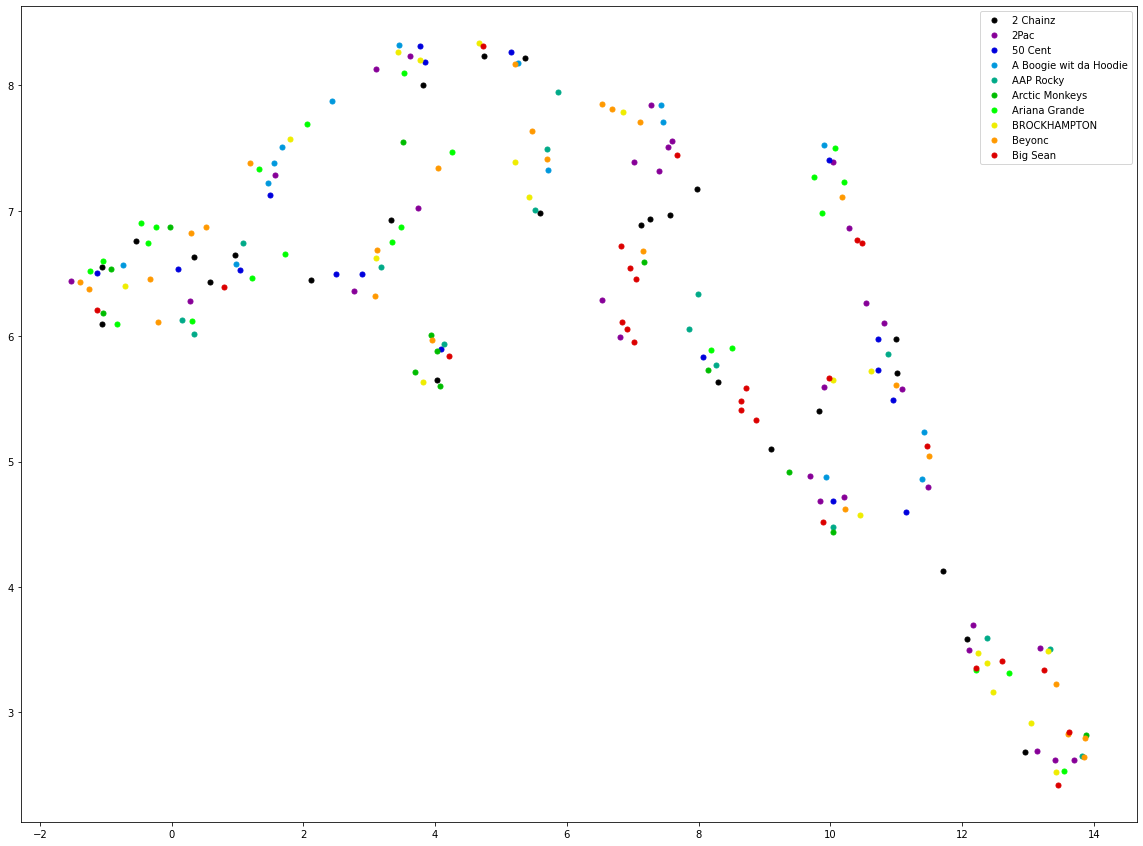

In [49]:
# Visualize the new embeddings 
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(test_loader, model)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings_reduced, labels.cpu().numpy(),artists_mappings)